In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')
warnings.filterwarnings('ignore', category=UserWarning, module='seaborn')
sns.set_palette("viridis")

# Set a base style
sns.set_style("whitegrid")

# Customize specific style parameters
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.color": "#cccccc",
    "axes.facecolor": "#f0f0f0",
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
}
sns.set_context("notebook", rc=custom_params)

In [2]:
from sklearn.datasets import fetch_openml

In [3]:
mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')

In [4]:
X, y = mnist.data, mnist.target

In [5]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [6]:
X.shape

(70000, 784)

In [7]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [8]:
y.shape

(70000,)

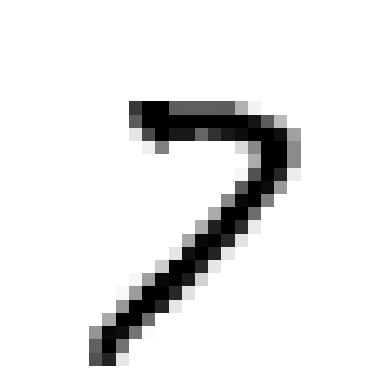

In [9]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

digit = X[567]
plot_digit(digit)
plt.show()

In [10]:
y[567]

'7'

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## let's try it with one classifier

In [12]:
y_train_7 = (y_train == '7')
y_test_7 = (y_test == '7')

In [13]:
from sklearn.linear_model import SGDClassifier

In [14]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_7)

SGDClassifier(random_state=42)

In [15]:
sgd_clf.predict([digit])

array([ True])

In [16]:
from sklearn.model_selection import cross_val_score

In [17]:
cross_val_score(sgd_clf, X_train, y_train_7, cv=3, scoring='accuracy')

array([0.98105, 0.9735 , 0.95335])

In [18]:
from sklearn.dummy import DummyClassifier

In [19]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_7)
print(dummy_clf.predict(X_train))

[False False False ... False False False]


In [20]:
cross_val_score(dummy_clf, X_train, y_train_7, cv=3, scoring='accuracy')

array([0.8956 , 0.8956 , 0.89555])

## Custom Cross Validation

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [22]:
skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_7):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_7[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_7[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.98105
0.9735
0.95335


In [23]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_7, cv=3)

In [24]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_7, y_train_pred)
cm

array([[52581,  1154],
       [  688,  5577]], dtype=int64)

In [25]:
y_train_perfect_pred = y_train_7
confusion_matrix(y_train_7, y_train_perfect_pred)

array([[53735,     0],
       [    0,  6265]], dtype=int64)

In [26]:
#Precision -> (TP / TP + FP)
print(5577/(1154+5577))

0.8285544495617293


In [27]:
#recall -> (TP / TP + FN)
print(5577/(688+5577))

0.8901835594573024


In [28]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_7, y_train_pred)

0.8285544495617293

In [29]:
recall_score(y_train_7, y_train_pred)

0.8901835594573024

In [30]:
from sklearn.metrics import f1_score

In [31]:
f1_score(y_train_7, y_train_pred)

0.8582640812557709

In [32]:
y_scores = sgd_clf.decision_function([digit])
y_scores

array([7642.3245373])

In [33]:
threshold = 0
y_digit_pred = y_scores > threshold
y_digit_pred

array([ True])

In [34]:
threshold = 9000
y_digit_pred = y_scores > threshold
y_digit_pred

array([False])

In [35]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_7, cv=3, method='decision_function')

In [36]:
from sklearn.metrics import precision_recall_curve

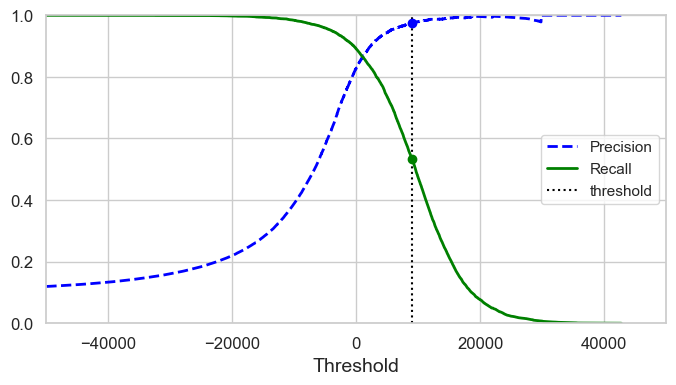

In [37]:
precisions, recalls, thresholds = precision_recall_curve(y_train_7, y_scores)

plt.figure(figsize=(8, 4))  
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

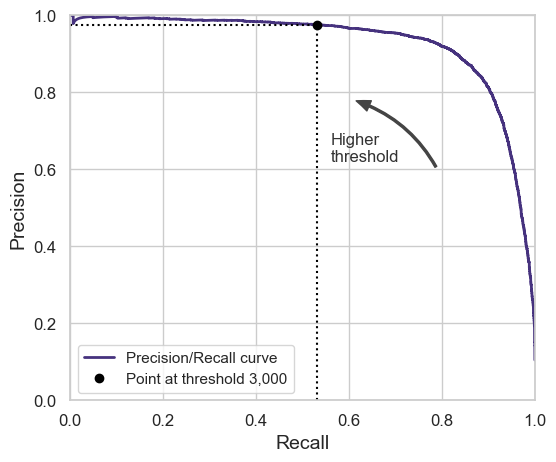

In [38]:
import matplotlib.patches as patches  

plt.figure(figsize=(6, 5)) 
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower left")

plt.show()

In [39]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

2288.724768166237

In [40]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)
precision_score(y_train_7, y_train_pred_90)

0.9000864304235091

In [41]:
recall_at_90_precision = recall_score(y_train_7, y_train_pred_90)
recall_at_90_precision

0.8311252992817239

In [42]:
from sklearn.metrics import roc_curve

In [43]:
fpr, tpr, thresholds = roc_curve(y_train_7, y_scores)

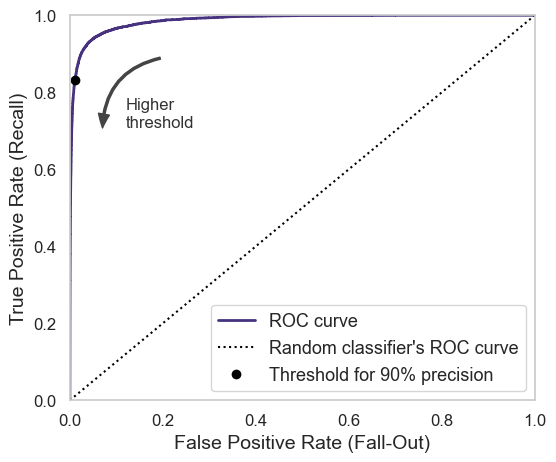

In [44]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()

In [45]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_7, y_scores)

0.986670497551944

In [46]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [47]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_7, cv=3,
                                    method="predict_proba")

In [48]:
y_probas_forest[:2]

array([[0.98, 0.02],
       [1.  , 0.  ]])

In [49]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_7, y_scores_forest)

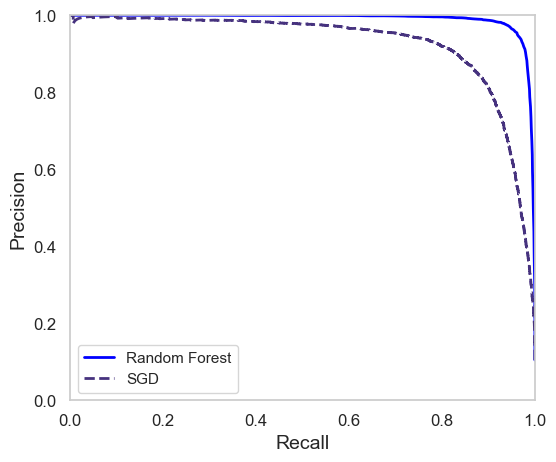

In [50]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# extra code – just beautifies and saves Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

In [51]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
f1_score(y_train_7, y_train_pred_forest)

0.9454182935947496

In [52]:
print(roc_auc_score(y_train_7, y_scores_forest))
print(precision_score(y_train_7, y_train_pred_forest))
print(recall_score(y_train_7, y_train_pred_forest))

0.9982747530426836
0.9857934857934858
0.9082202713487629


## Multiclass Classifications

In [53]:
from sklearn.svm import SVC

In [54]:
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [55]:
svm_clf.predict([digit])

array(['7'], dtype=object)

In [56]:
digit_scores = svm_clf.decision_function([digit])
digit_scores.round(2)

array([[ 3.77,  0.72,  7.27,  5.95,  2.73,  3.77, -0.29,  9.31,  2.75,
         8.28]])

In [58]:
class_id = digit_scores.argmax()
class_id

7

In [59]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [60]:
from sklearn.multiclass import OneVsRestClassifier

In [61]:
ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [63]:
ovr_clf.predict([digit])

array(['7'], dtype='<U1')

In [65]:
len(ovr_clf.estimators_)

10

In [66]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [67]:
sgd_clf.predict([digit])

array(['7'], dtype='<U1')

In [68]:
sgd_clf.decision_function([digit]).round(2)

array([[-16966.21, -28457.59,  -6842.84,  -3288.13, -18298.27, -18122.99,
        -37247.3 ,   7534.79,  -5352.01,   -821.77]])

In [69]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [70]:
from sklearn.preprocessing import StandardScaler

In [71]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype('float64'))

In [72]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

## Error analysis

In [73]:
from sklearn.metrics import ConfusionMatrixDisplay

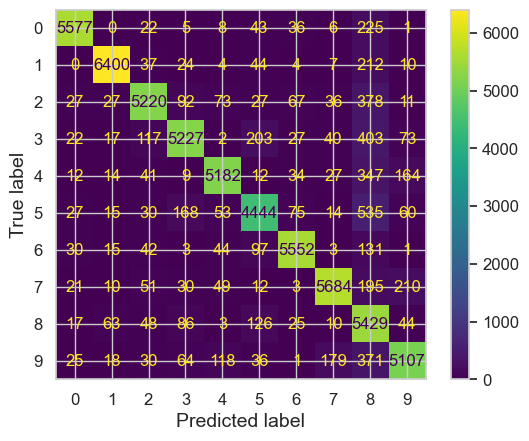

In [74]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

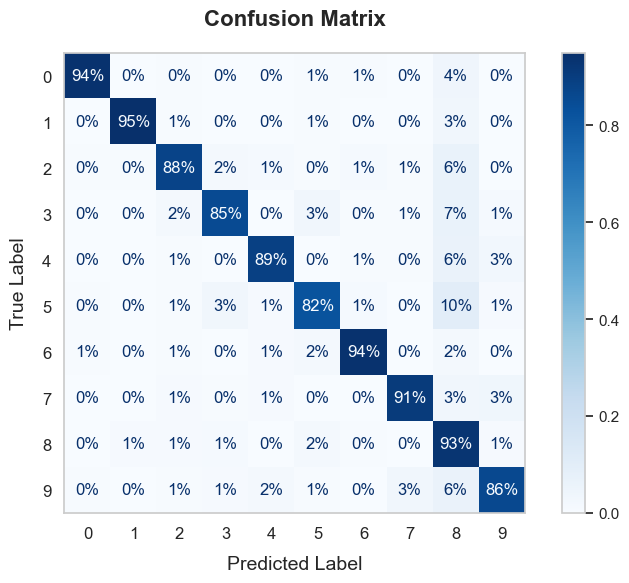

In [77]:
# Calculate confusion matrix
cm = confusion_matrix(y_train, y_train_pred, normalize='true')

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Customize the plot style for a publication look
plt.figure(figsize=(8, 6))
sns.set(style='whitegrid')  # Set style
ax = plt.gca()

# Display the matrix with custom parameters
disp.plot(cmap="Blues", values_format=".0%", ax=ax)

# Customizations for publication quality
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=14, labelpad=10)
plt.ylabel('True Label', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(False)

# Adjust the layout for better appearance
plt.tight_layout()
plt.show()

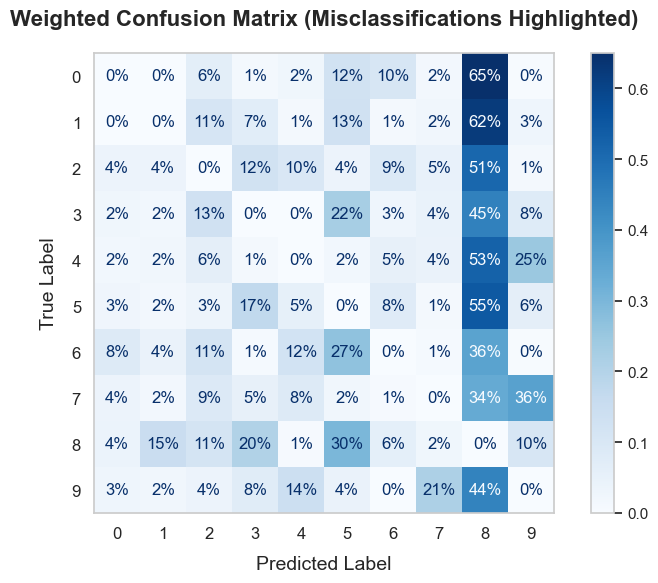

In [78]:
sample_weight = np.where(np.array(y_train) != np.array(y_train_pred), 1, 0)

# Calculate the confusion matrix with the sample weights
cm = confusion_matrix(y_train, y_train_pred, sample_weight=sample_weight, normalize='true')

# Create and style the confusion matrix display
plt.figure(figsize=(8, 6))
sns.set(style='whitegrid')  # Set style
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot with custom parameters
ax = plt.gca()
disp.plot(cmap="Blues", values_format=".0%", ax=ax)

# Customizations for publication quality
plt.title('Weighted Confusion Matrix (Misclassifications Highlighted)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=14, labelpad=10)
plt.ylabel('True Label', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(False)

# Adjust the layout
plt.tight_layout()
plt.show()

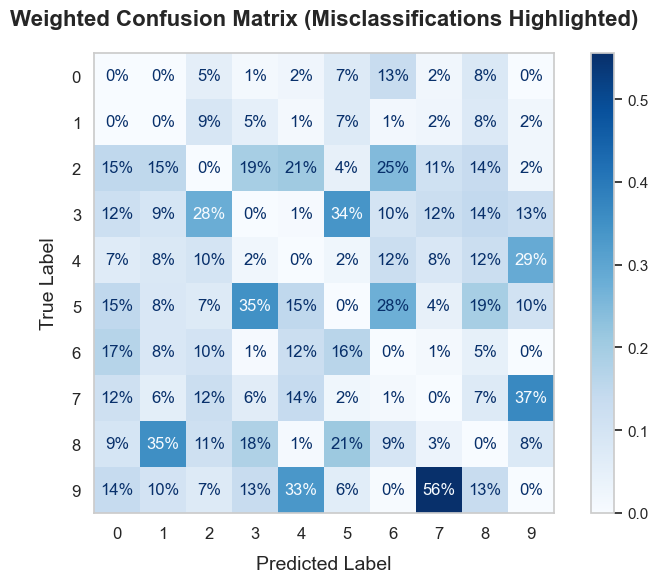

In [80]:
sample_weight = np.where(np.array(y_train) != np.array(y_train_pred), 1, 0)

# Calculate the confusion matrix with the sample weights
cm = confusion_matrix(y_train, y_train_pred, sample_weight=sample_weight, normalize='pred')

# Create and style the confusion matrix display
plt.figure(figsize=(8, 6))
sns.set(style='whitegrid')  # Set style
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot with custom parameters
ax = plt.gca()
disp.plot(cmap="Blues", values_format=".0%", ax=ax)

# Customizations for publication quality
plt.title('Weighted Confusion Matrix (Misclassifications Highlighted)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=14, labelpad=10)
plt.ylabel('True Label', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(False)

# Adjust the layout
plt.tight_layout()
plt.show()

## Multilabel Classification

In [81]:
from sklearn.neighbors import KNeighborsClassifier

In [82]:
y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 ==1)
y_multiple = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multiple)

KNeighborsClassifier()

In [83]:
knn_clf.predict([digit])

array([[ True,  True]])

In [84]:
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

In [85]:
y_train_mod = X_train
y_test_mod = X_test

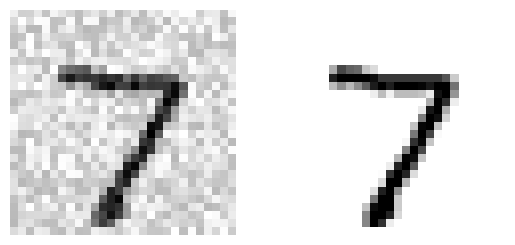

In [86]:
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
plt.show()

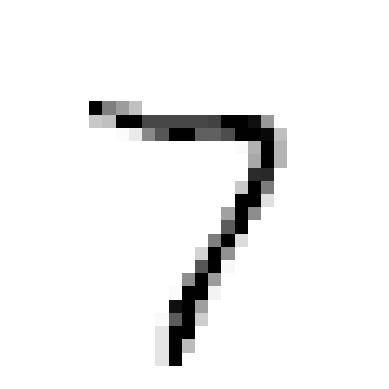

In [88]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()